### Import Libraries

In [88]:
!pip install keras_tqdm

In [89]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array, ImageDataGenerator)

# nice progress bars for learning
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import numpy as np
import pandas as pd
import time
import itertools
import os,re,string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

#nltk related libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

print(tf.__version__)
print(nltk.__version__)

2.5.0
3.2.5


In [90]:
# verify GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [91]:
# set consistent random seed
random_seed = 62
np.random.seed(random_seed)  
tf.random.set_seed(random_seed)

In [92]:
#Overall Program Execution Time
program_start_time = time.time()

### Load data from IMDB site, and unpacking data files for further processing

In [93]:
# Load files from the site, and unpack them for further processing
!pwd
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!gunzip aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [94]:
# Verify the loaded files
PATH='aclImdb/'
names = ['neg','pos']
!ls {PATH}
!ls {PATH}train
!ls {PATH}train/pos | head

#Similar for the test folder
!ls {PATH}test
!ls {PATH}test/pos | head

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt


In [95]:
# Loadng the files from folders into data structure
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)

trn,trn_y = load_texts_labels_from_folders(f'{PATH}train',names)
val,val_y = load_texts_labels_from_folders(f'{PATH}test',names)

print("Load Summary")
print("-"*12)
print("Reviews: train->", len(trn), ", test-> ", len(val))
print("Sentiments: train->", len(trn_y),", test->", len(val_y))
print("Unique class: ", np.unique(trn_y))
print("Unique class: ", np.unique(val_y))
print("Train: postive->", len(trn_y[trn_y==1]),", negative->", len(trn_y[trn_y==0]))
print("Test: postive->", len(val_y[val_y==1]),", negative->", len(val_y[val_y==0]))
print("Review dtype: ", type(trn), ". Sentiment dtype", type(trn_y))

Load Summary
------------
Reviews: train-> 25000 , test->  25000
Sentiments: train-> 25000 , test-> 25000
Unique class:  [0 1]
Unique class:  [0 1]
Train: postive-> 12500 , negative-> 12500
Test: postive-> 12500 , negative-> 12500
Review dtype:  <class 'list'> . Sentiment dtype <class 'numpy.ndarray'>


In [96]:
# Review loaded data
print(trn[0])
print()
print(f"Review's label: {trn_y[0]}")
# 0 represent a negative review

...however I am not one of them. Caro Diario at least was watchable for two thirds of the time, but the boring and self-centred third section of that movie gave us a taste of what was to come in this extraordinarily self-indulgent mess. Moretti says he feels a need to make this movie, but doesn't want to, whereas the viewer feels that he should stick with it, but really doesn't want to either. A film about Italian politics and elections could be fascinating, but this is not that film. At one point, Moretti and his friends are standing outside the Communist Party headquarters, discussing the interviews they are preparing to conduct with Party leaders inside, but it's characteristic of this film that we never get to see anything of them. Interposed with Moretti's political ravings are the events leading up to the birth of his son, and subsequent home movie shots of him with the baby and later the infant Pietro (the film drags us through several years and more than one election period). W

### Combining individual array into dataframe, so that we can visualise data and also have 80:20 train test data split

In [97]:
# Loading training data in dataframe
imdb_data_0 = pd.DataFrame(
    {'review': trn,
     'sentiment': trn_y
    })

# Loading test data in dataframe
imdb_data_1 = pd.DataFrame(
    {'review': val,
     'sentiment': val_y
    } )

# Combining both data frame into single data frame, and also encoding sentiments into 'pos', 'neg'
imdb_data = pd.concat([imdb_data_0, imdb_data_1])
imdb_data.loc[(imdb_data.sentiment == 0),'sentiment']='neg'
imdb_data.loc[(imdb_data.sentiment == 1),'sentiment']='pos'
imdb_data.head()

,review,sentiment
0,...however I am not one of them. Caro Diario a...,neg
1,"Yes, the first ""Howling"" was a classic. A rath...",neg
2,The only way this is a family drama is if pare...,neg
3,This was the worst movie I saw at WorldFest an...,neg
4,DO NOT WATCH THIS SAD EXCUSE FOR A FILM. I hav...,neg


### Evaluating Data

In [98]:
# Shape of DF
print(imdb_data.shape)

#Summary of the dataset
imdb_data.describe()

(50000, 2)


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,neg
freq,5,25000


In [99]:
# Exploring data
print("Categories:", np.unique(imdb_data.sentiment))
print("Number of unique words:", len(np.unique(np.hstack(imdb_data.review))))

length = [len(i) for i in imdb_data.review]
print("Average Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))

Categories: ['neg' 'pos']
Number of unique words: 49582
Average Review length: 1309.43102
Standard Deviation: 990


**Summary** <br/>
Dataset is labeled into two categories, — 'neg' or 'pos', which represents the sentiment of the review. The whole dataset contains 49,582 unique words and the average review length is 1309 words, with a standard deviation of 990 words.

### Print at least two texts from each class of the dataset(pos and neg), for a sanity check that labels match the text.

In [100]:
imdb_data.groupby('sentiment').head(2)

,review,sentiment
0,...however I am not one of them. Caro Diario a...,neg
1,"Yes, the first ""Howling"" was a classic. A rath...",neg
12500,"Erich Rohmer's ""L'Anglaise et le duc"" makes a ...",pos
12501,There were times when this movie seemed to get...,pos


### Plot a bar graph of class distribution in a dataset. Each bar depicts the number of texts belonging to a particular sentiment.

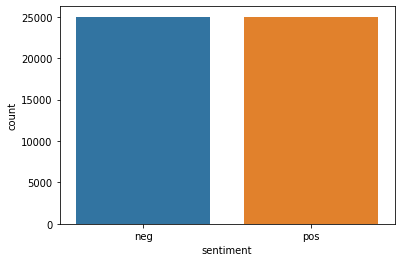

In [101]:
sns.countplot(x='sentiment', data=imdb_data)

## Data Preprocessing

In [102]:
# Since the models accept string inputs or cannot be of the string format, we have to come up with a way of handling this step. 
# As advised for this we use this pre-trained embedding layer (https://tfhub.dev/google/nnlm-en-dim128/1) from TensorFlow hub for this assignment. 
# This converts a sentence to a vector. 

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")

review_str_to_vector = embed(imdb_data.review)
review_str_to_vector

<tf.Tensor: shape=(50000, 128), dtype=float32, numpy=
array([[ 1.7375699e+00,  1.3065730e-01,  1.3863964e-02, ...,
        -2.7825180e-01, -9.0517431e-02,  1.1714965e-01],
       [ 1.6903697e+00, -1.3557440e-01,  1.4690079e-01, ...,
        -3.0410147e-01,  1.7804345e-01,  1.2329679e-01],
       [ 9.8199713e-01, -1.3707671e-02,  1.3825563e-01, ...,
        -2.4756120e-01,  6.0418341e-02, -2.8576680e-02],
       ...,
       [ 9.2993855e-01,  5.0744731e-03,  1.0189215e-01, ...,
        -1.9302624e-01, -1.4884113e-01,  1.9643065e-02],
       [ 1.0408282e+00,  1.4323031e-03, -5.5927113e-02, ...,
        -3.2236207e-01, -9.1123737e-02,  1.7989163e-01],
       [ 1.4293753e+00,  1.4468416e-02,  2.1096990e-01, ...,
        -1.7056543e-01, -1.5976247e-01,  1.1397619e-01]], dtype=float32)>

### Print the shapes of train and test data.

In [103]:
# Original
print("Original (data) Training: ", imdb_data_0.shape)
print("Original (data) Test: ", imdb_data_1.shape)

# Revised
X_train, X_test, y_train, y_test = train_test_split(imdb_data.review, imdb_data.sentiment, test_size=0.20, random_state=42)

#converting sentiment values back to numerical 0, 1
y_train = y_train.replace({'pos': 1, 'neg': 0})
y_test = y_test.replace({'pos': 1, 'neg': 0})

print("Revised Training: ", X_train.shape, y_train.shape)
print("Revised Test: ", X_test.shape, y_test.shape)

Original (data) Training:  (25000, 2)
Original (data) Test:  (25000, 2)
Revised Training:  (40000,) (40000,)
Revised Test:  (10000,) (10000,)


### Build N/w Model

In [104]:
# Build the model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
# Layer 1 : converting the string to vector
model.add(hub_layer)
# Layer 2 : Relu
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Adding Droput with 20%, towards the end before output as when we did try out other combination we got min validation loss for this configuration
# drop out last : loss: 0.4838 - accuracy: 0.7865 - val_loss: 0.4768 - val_accuracy: 0.7897
# drop out 1st : loss: 0.5277 - accuracy: 0.7541 - val_loss: 0.4967 - val_accuracy: 0.7812
# drop out inbetween : loss: 0.4972 - accuracy: 0.7822 - val_loss: 0.4794 - val_accuracy: 0.7940
model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))

# Layer 3 : Output Sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dense_30 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_31 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 124,651,739
Trainable params: 9,051
Non-trainable params: 124,642,688
_________________________________________________________________


### Model compile

In [105]:
# As our analysis is for positive / negative sentiment classification (binary) we use loss function as binary crossentropy
# Using default learning rate
# Model compile
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

### Fit model 

In [106]:
start_time = time.time()

# using default batch size for now, batch_size = 500 
results = model.fit(
 X_train, y_train,
 epochs= 10,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

Epoch 1/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6439 - accuracy: 0.7594 - val_loss: 0.5226 - val_accuracy: 0.7902
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5232 - accuracy: 0.7819 - val_loss: 0.5056 - val_accuracy: 0.7896
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5112 - accuracy: 0.7801 - val_loss: 0.4927 - val_accuracy: 0.7937
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5042 - accuracy: 0.7847 - val_loss: 0.4875 - val_accuracy: 0.7928
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4989 - accuracy: 0.7846 - val_loss: 0.4841 - val_accuracy: 0.7924
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4941 - accuracy: 0.7856 - val_loss: 0.4890 - val_accuracy: 0.7885
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4910 - accuracy: 0.7855 - val_loss: 0.4969 - val_accuracy:

### Model Evaluation

In [107]:
print(np.mean(results.history["val_accuracy"]))
#results.history

0.7907599985599518


### Plotting Results

In [108]:
def plot_hist_loss_acc(results):
  #results.history
  accuracy = results.history['accuracy']
  loss = results.history['loss']
  val_accuracy = results.history['val_accuracy']
  val_loss = results.history['val_loss']

  epochs = range(1,len(accuracy)+1)

  plt.plot(epochs, accuracy, 'bo', label='Training Acc')
  plt.plot(epochs, val_accuracy, 'b', label='Validation Acc')
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title("Training and validation Loss")
  plt.legend()
  plt.figure()


def plot_hist_loss_acc_v2(results):
  #results.history
  pd.DataFrame(results.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1) # set vertical range to [0-1]
  plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

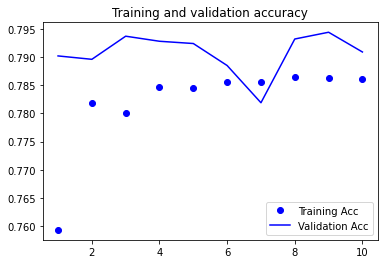

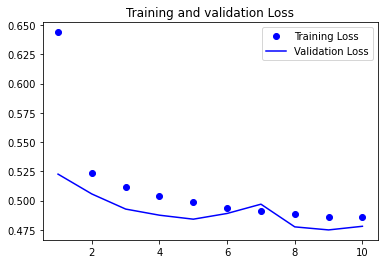

<Figure size 432x288 with 0 Axes>

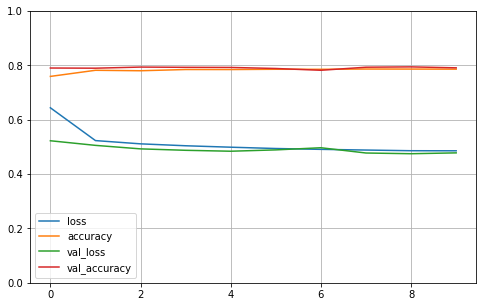

In [109]:
plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

### Confusion Matrix and Classification Report

F1-score: 0.7743606345095501
Classification Report:
              precision    recall  f1-score   support

         neg       0.76      0.85      0.81      5055
         pos       0.83      0.73      0.77      4945

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



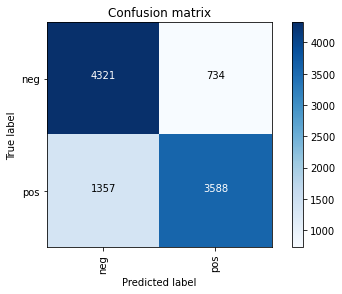

In [110]:
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
from sklearn.metrics import f1_score, confusion_matrix, classification_report
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))

#confusion_matrix(y_pred, y_test)
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['neg','pos']))
# confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes = ['neg','pos'])

**Summary** <br/> Both the class are performing equally, with negative class have f1-score of 80% as against 79% for positive reviews
<br>
From Confusion Matrix, 900+ negative classes are misclassified as positive whlie for positive this count is 1112, so negative review class is marginally performing better 

In [111]:
# Analysing Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# use float to perform true division, not integer division
print("Classification Accuracy: Overall, how often is the classifier correct?")
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

print()
# use float to perform true division, not integer division
print("Classification Error (Misclassification Rate): Overall, how often is the classifier incorrect?")
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred))

print()
# Something we want to maximize, How "sensitive" is the classifier to detecting positive instances?
print("Sensitivity: When the actual value is positive, how often is the prediction correct?")
print(TP / float(FN + TP))
print(metrics.recall_score(y_test, y_pred))

print()
# Something we want to maximize, How "specific" (or "selective") is the classifier in predicting positive instances?
print("Specificity: When the actual value is negative, how often is the prediction correct?")
print(TN / (TN + FP))

print()
print("False Positive Rate: When the actual value is negative, how often is the prediction incorrect?")
print(FP / float(TN + FP))

print()
print("Precision: When a positive value is predicted, how often is the prediction correct?")
print(TP / float(TP + FP))

print()
# print the first 10 true and predicted responses
print('Test:', y_test.values[0:10])
print('Predict:', *y_pred[0:10])

Classification Accuracy: Overall, how often is the classifier correct?
0.7909
0.7909

Classification Error (Misclassification Rate): Overall, how often is the classifier incorrect?
0.2091
0.20909999999999995

Sensitivity: When the actual value is positive, how often is the prediction correct?
0.7255813953488373
0.7255813953488373

Specificity: When the actual value is negative, how often is the prediction correct?
0.8547972304648862

False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
0.14520276953511374

Precision: When a positive value is predicted, how often is the prediction correct?
0.8301712170291532

Test: [0 0 0 0 1 1 0 1 0 0]
Predict: [ True] [False] [False] [False] [ True] [ True] [False] [ True] [False] [False]


**Summary** <br/>
Our classifier
- Highly specific
- Sensitive

### Print the two most incorrectly classified texts for each class in the test dataset.

In [112]:
count_1 = 0
count_0 = 0
idx = 0

for i, v in y_test.items():
  if(count_1 < 2 or count_0 < 2):
    #print(count_1, count_0)
    if(count_1 < 2 and v == 1 and v != y_pred[idx]):
      count_1 += 1
      print(count_1, " Positive Mismatch\n",X_test[i])
    if(count_0 < 2 and v == 0 and v != y_pred[idx]):
      count_0 += 1
      print(count_0, " Negative Mismatch\n",X_test[i])
  idx += 1

1  Negative Mismatch
 it's the best film that takes the first place at the sickest and an useful films ever made in this poor country. really u people even don't know what the word cinema means and u cast votes for movies, i'm really curious to know how many movies of P.P.P. or L.Bunuel have u seen. The score of this "faield experiment" it reflects a lot of u're way of understanding things and to recognize a good/quality movie when u see it. We the Romanian people have only ONE movie and until this day the status hasn't change & that movie is "Padurea Spanzuratilor". But I don't lose my time thinking how many of you have seen it. That is a movie that respects all the required quality's's of an MOVIE. From the script to the frames and even to the quality/clarity of the picture even are past over him 41 years. I recommend to the voters to search for better movies and then vote. KuDos will See u later .
2  Negative Mismatch
 6188    I expected to enjoy a romantic comedy featurin...
6188  

### Hyperparameter Tuning- Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

### Write a comparison between each model and give reasons for the difference in results.

#### Batch Size: Change the value of batch size in model training

In [113]:
# Batch Size = 500
start_time = time.time()

results = model.fit(
 X_train, y_train,
 epochs= 10,
 batch_size = 500,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

Epoch 1/10
80/80 [==============================] - 3s 33ms/step - loss: 0.4762 - accuracy: 0.7925 - val_loss: 0.4690 - val_accuracy: 0.7960
Epoch 2/10
80/80 [==============================] - 2s 30ms/step - loss: 0.4732 - accuracy: 0.7934 - val_loss: 0.4686 - val_accuracy: 0.7958
Epoch 3/10
80/80 [==============================] - 2s 30ms/step - loss: 0.4729 - accuracy: 0.7928 - val_loss: 0.4693 - val_accuracy: 0.7995
Epoch 4/10
80/80 [==============================] - 2s 30ms/step - loss: 0.4721 - accuracy: 0.7946 - val_loss: 0.4675 - val_accuracy: 0.7983
Epoch 5/10
80/80 [==============================] - 2s 30ms/step - loss: 0.4718 - accuracy: 0.7939 - val_loss: 0.4671 - val_accuracy: 0.7977
Epoch 6/10
80/80 [==============================] - 2s 30ms/step - loss: 0.4725 - accuracy: 0.7933 - val_loss: 0.4674 - val_accuracy: 0.7960
Epoch 7/10
80/80 [==============================] - 2s 28ms/step - loss: 0.4720 - accuracy: 0.7936 - val_loss: 0.4678 - val_accuracy: 0.7992
Epoch 8/10
80

In [114]:
print(np.mean(results.history["val_accuracy"]))
#results.history

0.797789990901947


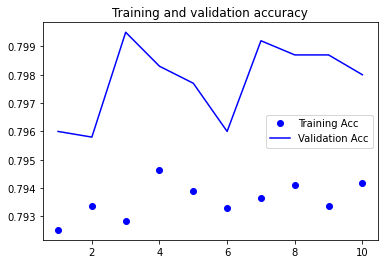

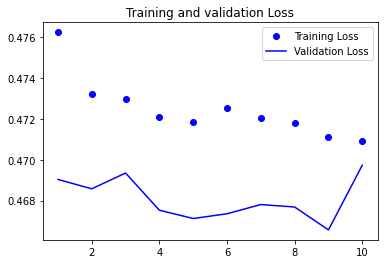

<Figure size 432x288 with 0 Axes>

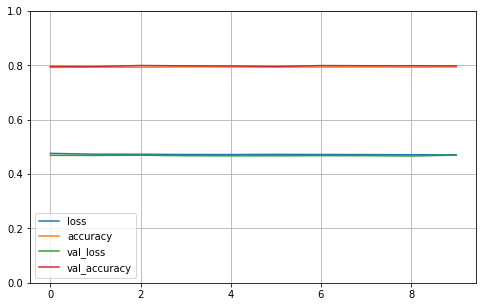

In [115]:
plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

In [116]:
# Batch Size = 100
start_time = time.time()

results = model.fit(
 X_train, y_train,
 epochs= 10,
 batch_size = 100,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

Epoch 1/10
400/400 [==============================] - 5s 11ms/step - loss: 0.4761 - accuracy: 0.7924 - val_loss: 0.4686 - val_accuracy: 0.7977
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4749 - accuracy: 0.7914 - val_loss: 0.4760 - val_accuracy: 0.7920
Epoch 3/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4752 - accuracy: 0.7907 - val_loss: 0.4698 - val_accuracy: 0.7985
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4746 - accuracy: 0.7915 - val_loss: 0.4677 - val_accuracy: 0.7987
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4715 - accuracy: 0.7930 - val_loss: 0.4653 - val_accuracy: 0.8000
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.4729 - accuracy: 0.7918 - val_loss: 0.4625 - val_accuracy: 0.7985
Epoch 7/10
400/400 [==============================] - 4s 11ms/step - loss: 0.4714 - accuracy: 0.7923 - val_loss: 0.4631 - val_accuracy: 0.7981

In [117]:
print(np.mean(results.history["val_accuracy"]))
#results.history

0.7966599941253663


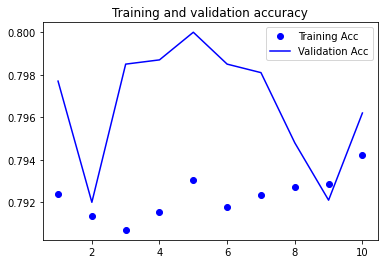

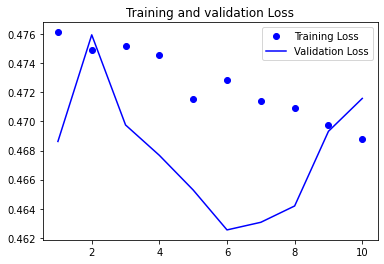

<Figure size 432x288 with 0 Axes>

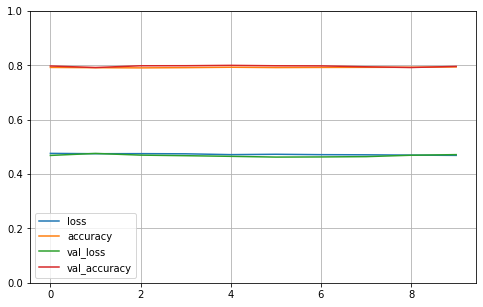

In [118]:
plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

#### Batch Size Summary <br>
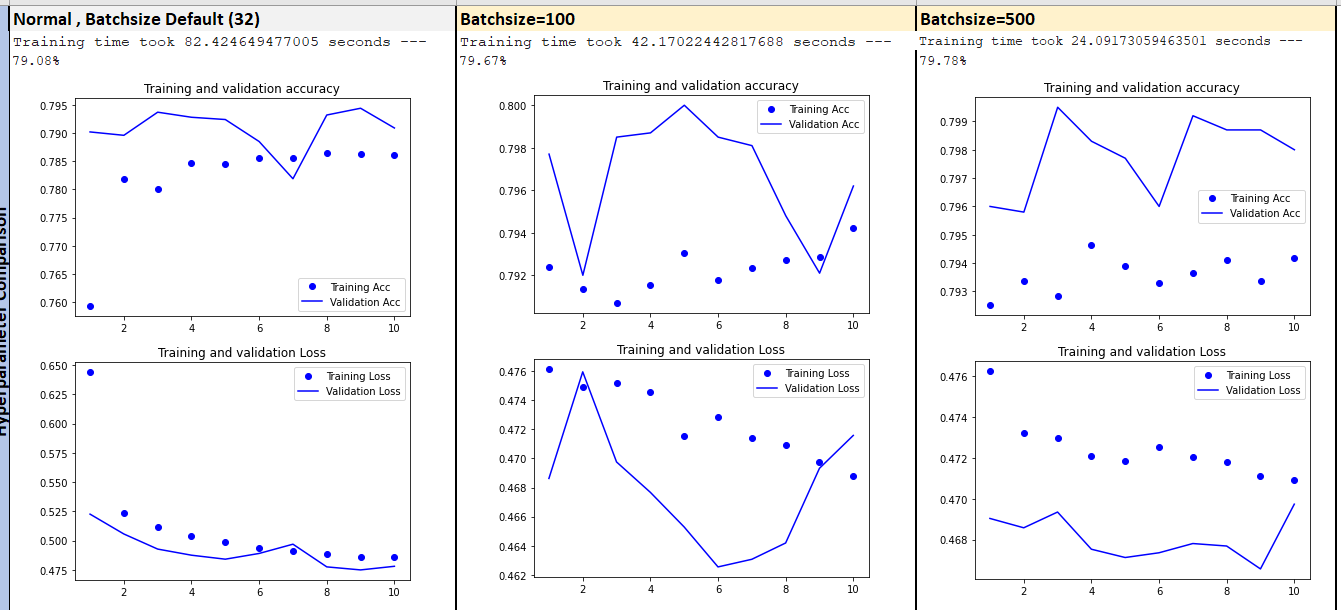
<br>
The batch size defines the number of samples that will be propagated through the network and an epoch is an iteration over the entire training data. In general, a larger batch size results in faster training, but doesn't always converge as fast (training losses are minimised but while validation resulted in higher loss, likewise for accuracy also training accuracy is high while validation accuracy is low).A smaller batch size is slower in training but it can converge faster.

#### Dropout: Change the position and value of dropout layer

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 124,651,739
Trainable params: 9,051
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6704 - accuracy: 0.7300

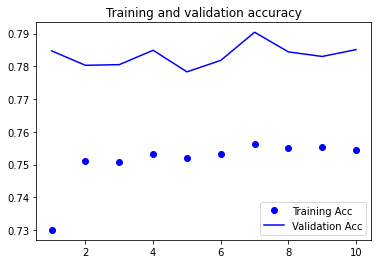

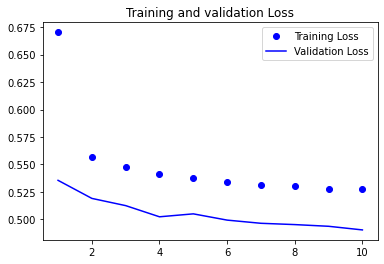

<Figure size 432x288 with 0 Axes>

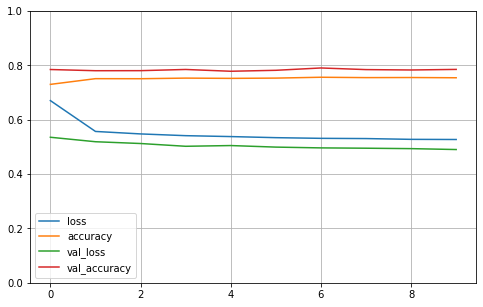

In [119]:
# Build the model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
# Layer 1 : converting the string to vector
model.add(hub_layer)

# Adding Droput with 20%, after input
model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))

# Layer 2 : Relu
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))


# Layer 3 : Output Sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# Model compile
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

start_time = time.time()

# Keeping default batch size
results = model.fit(
 X_train, y_train,
 epochs= 10,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

print(np.mean(results.history["val_accuracy"]))
#results.history

plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_13 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dense_36 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 51        
Total params: 124,651,739
Trainable params: 9,051
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6461 - accuracy: 0.7504

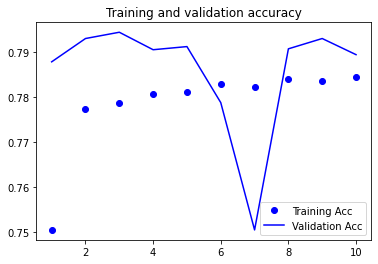

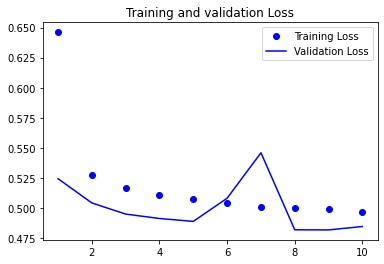

<Figure size 432x288 with 0 Axes>

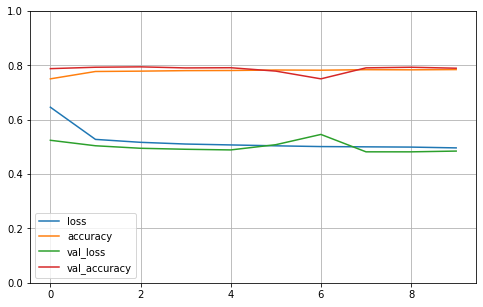

In [120]:
# Build the model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
# Layer 1 : converting the string to vector
model.add(hub_layer)

# Layer 2 : Relu
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Adding Droput with 20%, inbetween layer
model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))

model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Layer 3 : Output Sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# Model compile
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

start_time = time.time()

# Keeping default batch size
results = model.fit(
 X_train, y_train,
 epochs= 10,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

print(np.mean(results.history["val_accuracy"]))
#results.history

plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_14 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dense_39 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 124,651,739
Trainable params: 9,051
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6497 - accuracy: 0.7614

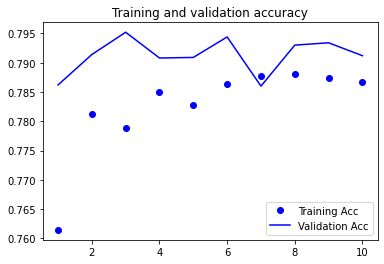

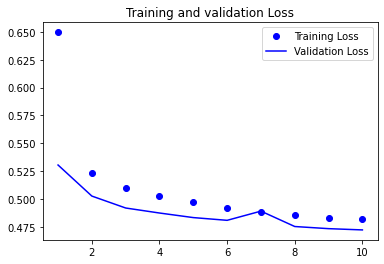

<Figure size 432x288 with 0 Axes>

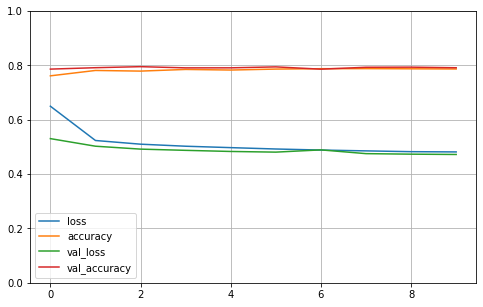

In [121]:
# Build the model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
# Layer 1 : converting the string to vector
model.add(hub_layer)
# Layer 2 : Relu
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Adding Droput with 20%, before output
model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))

# Layer 3 : Output Sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# Model compile
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

start_time = time.time()

# Keeping default batch size
results = model.fit(
 X_train, y_train,
 epochs= 10,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

print(np.mean(results.history["val_accuracy"]))
#results.history

plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_15 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dense_42 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_43 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 124,651,739
Trainable params: 9,051
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6636 - accuracy: 0.7496

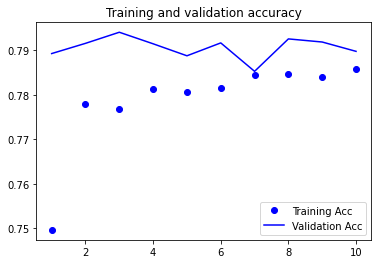

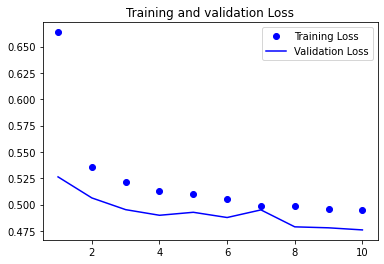

<Figure size 432x288 with 0 Axes>

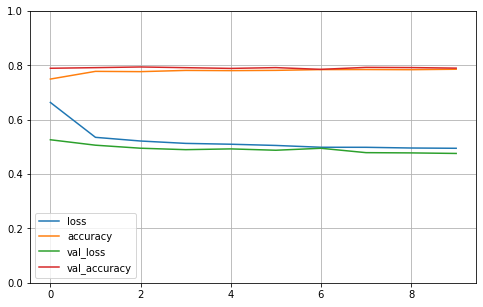

In [122]:
# Build the model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
# Layer 1 : converting the string to vector
model.add(hub_layer)
# Layer 2 : Relu
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.01), activation='relu'))

# Adding Droput with 50%, before output
model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))

# Layer 3 : Output Sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# Model compile
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

start_time = time.time()

# Keeping default batch size
results = model.fit(
 X_train, y_train,
 epochs= 10,
 validation_data = (X_test, y_test)
)

print("Training time took %s seconds ---" % (time.time() - start_time))

print(np.mean(results.history["val_accuracy"]))
#results.history

plot_hist_loss_acc(results)
plot_hist_loss_acc_v2(results)

#### Drop out Summary

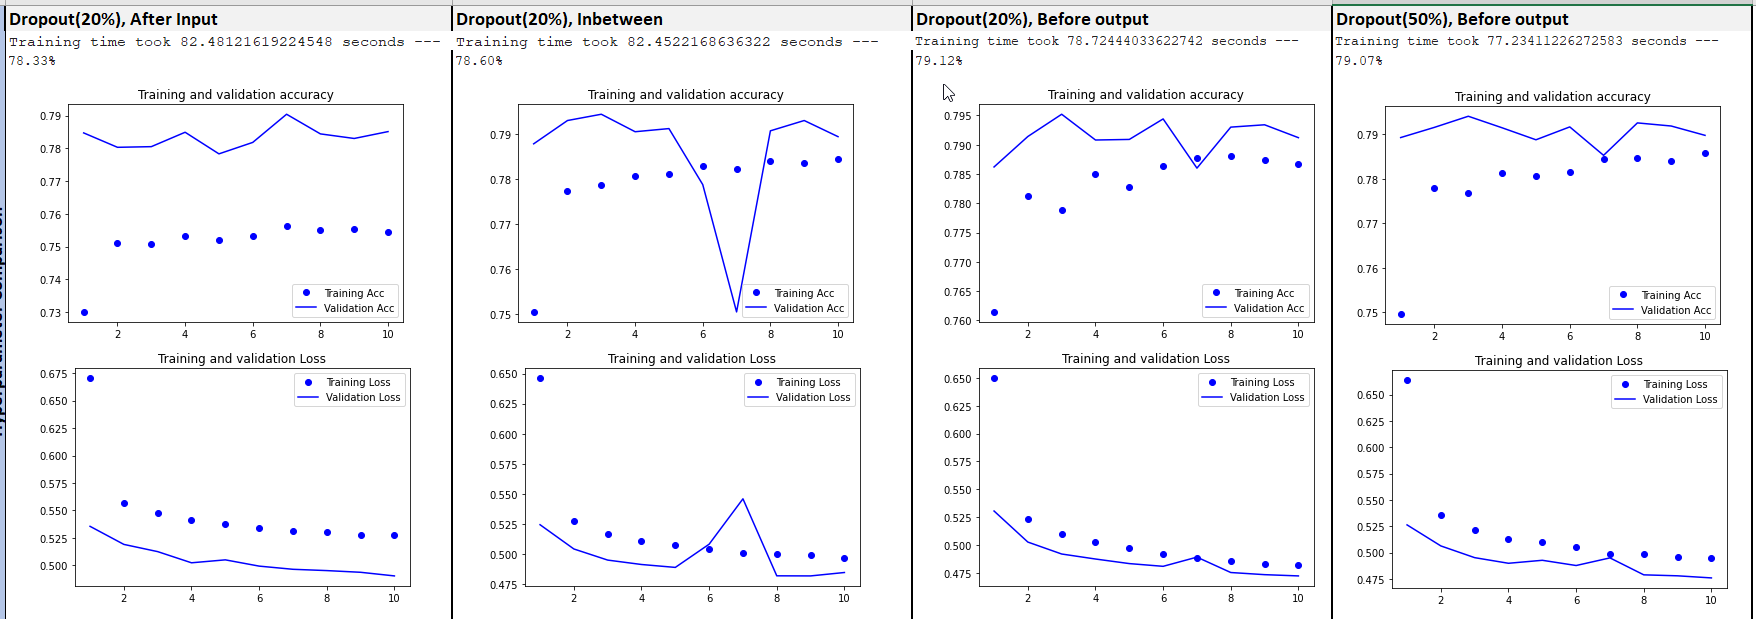
<br>
Adding dropout helps prevent overfitting. The loss and accuracy of training and validation almost converges. We get better validation accuracy when we add dropout just before the output layer, but if we increase dropout % it leads to slight drop in accuracy

In [123]:
secs = time.time() - program_start_time
mins = secs / 60
print("Overall time took %s seconds ---" % "{:.2f}".format(secs))
print("Overall time took %s mins ---" % "{:.2f}".format(mins))

Overall time took 579.06 seconds ---
Overall time took 9.65 mins ---
